#Introduction
It is well known that models such as Multilayer perceptrons (MLP) and convolutonal neural nets do not perform well when it comes to learning from long text snippets (They fails to capture the long term dependencies betwen words). LSTM tries to mitigate the problem but falls short for longer texts.  In this notebook I train a custom transformer to aid the binary classification of long text. The dataset used is the IMDB movie reviews dataset. The dataset has an average of 323 words per review. The task is to classify each review as either holding a positive or negative sentiment.

This version uses the pretrained bert embeddings (not the complete bert model)

**Author: Hemed K**

# Initial setup

Connect to google drive to access the data and change the working directory from "/content" to where this notebook and data resides in the googe drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Github/text-classification/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Github/text-classification


Install and importing necessary packages, pandas is for holding and visualizing the data while torch models are for actually implementing and training the transformer. Sklearn is for evaluation metrics.

In [ ]:
!pip  install transformers

In [ ]:
import pandas as pd

from transformers import BertTokenizer, BertModel

import torch, utils, os, sys, pickle,itertools, math
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
#from torch.nn import TransformerEncoder, TransformerEncoderLayer

Set seed to guarantee reproducibility.

In [ ]:
SEED = 1234
torch.manual_seed(SEED)

# Read and visualize the data

In [ ]:
def str_to_int(x: str) -> int:
    '''
    Takes in a string labels i.e. positive or negative
    Converts it into a number 1 or 0 respectively
    '''
    if x=="positive": return 1
    else: return 0

In [ ]:
data_path ='data/IMDB-movie-reviews.csv'
df = pd.read_csv(data_path, sep=',', delimiter=None, header='infer')
df['label'] = df['sentiment'].apply(str_to_int)
print (df.shape)
df.head()

(50000, 3)


,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


Split the data into train, validation and test sets. 

In [ ]:
def split_data(df):
    '''
    Takes in a dataframe and splits it into 3 sub dataframes
    In the ration of 80%,10%,10% for training, validating and testing respectively. 
    '''
    train_df, valid_df = train_test_split(df, test_size=0.2, shuffle=True)
    valid_df, test_df = train_test_split(valid_df, test_size=0.5, shuffle=True)
    return train_df, valid_df, test_df

In [ ]:
train_df, valid_df, test_df = split_data(df)

# Preprocess the data

Define the tokenizer (preprocessor) and apply it to the dataset. The preprocessing activities done by the tokenizer includes converting each character to a lower case, tokenizing the documents, padding them if doc tokens are shorter than maximum model required length and truncates the docs if doc tokens are longer than the max model required length. Finaly converts the tokens into their ids as they appear in the model's embeddings listing.

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
tokenized_train_data = tokenizer(train_df['review'].tolist(), padding=True, truncation=True)
tokenized_valid_data = tokenizer(valid_df['review'].tolist(), padding=True, truncation=True)
tokenized_test_data = tokenizer(test_df['review'].tolist(), padding=True, truncation=True)

Convert the dataset into a pytorch format.

In [ ]:
class ReviewsDataset(Dataset):
      '''
      A custom pytorch dataset
      '''
      def __init__(self, reviews, labels):
          self.reviews = reviews
          self.labels = labels
    
      def __len__(self):
          return len(self.labels)
          

      def __getitem__(self, idx):
          item = {key: torch.tensor(val[idx]) for key, val in self.reviews.items()}
          item['label'] = torch.tensor(self.labels[idx])
          return item
          

In [ ]:
train_dataset = ReviewsDataset(tokenized_train_data, train_df['label'].tolist())
valid_dataset = ReviewsDataset(tokenized_valid_data, valid_df['label'].tolist())
test_dataset = ReviewsDataset(tokenized_test_data, test_df['label'].tolist())

Create a dataloader to facilitate iteration over batches of data.

In [ ]:
batch_size = 4
n_workers = 0
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=n_workers, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=n_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=n_workers)

#The model

In [ ]:
class PositionalEncoding(nn.Module):

  def __init__(self, d_model, dropout=0.1, max_len=5000):
      super(PositionalEncoding, self).__init__()
      self.dropout = nn.Dropout(p=dropout)

      pe = torch.zeros(max_len, d_model)
      position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
      div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
      pe[:, 0::2] = torch.sin(position * div_term)
      pe[:, 1::2] = torch.cos(position * div_term)
      pe = pe.unsqueeze(0).transpose(0, 1)
      self.register_buffer('pe', pe)

  def forward(self, x):
      x = x + self.pe[:x.size(0), :]
      return self.dropout(x)

In [ ]:
class TransformerModel(nn.Module):

  def __init__(self, embed_dim, nhead, nlayers, dropout, attn_dim, out_dim, tokens_per_review): 
      super(TransformerModel, self).__init__()

      self.embed_dim = embed_dim
      self.embed_layer = BertModel.from_pretrained("bert-base-uncased").embeddings.word_embeddings
      self.embed_layer.weight.requires_grad = True

      self.pos_encoder = PositionalEncoding(embed_dim, dropout)
      self.transformer_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(embed_dim, nhead, attn_dim, dropout), nlayers)
      self.out_layer = nn.Linear(embed_dim*tokens_per_review, out_dim)

     

  def forward(self, inpt): 
      embeds = self.embed_layer(inpt) * math.sqrt(self.embed_dim)        
      embeds = self.pos_encoder(embeds)
      out = self.transformer_encoder(embeds)
      out = out.view(out.shape[0], -1) 
      out = self.out_layer(out)
      scores = nn.functional.log_softmax(out, dim=1) 
      return scores


# Training and validating

Initialize training and model parameters


In [ ]:
n_epochs = 10
learning_rate = 0.0001

embed_dim = 768
nhead = 2
nlayers = 2
dropout = 0.1
attn_dim = 100
out_dim = 2
tokens_per_review = 512

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerModel(embed_dim, nhead, nlayers, dropout, attn_dim, out_dim, tokens_per_review).to(device)
loss_function = nn.NLLLoss()
optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad == True], lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def train(model,data_loader):
    '''
    Training the model
    '''
    model.train()
    losses = []
    for batch in data_loader:
        
        batch_reviews = batch['input_ids'].to(device)
        batch_labels = batch['label'].to(device)

        optimizer.zero_grad()
        model_output = model(batch_reviews)

        loss = loss_function(model_output, batch_labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
    mean_loss = sum(losses)/len(losses)
    return mean_loss

In [ ]:
def evaluate(model, data_loader):
    '''
    Model evaluation
    '''
    model.eval()
    actuals = []
    predictions = []
    losses = []
    with torch.no_grad():
         for batch in data_loader:
         
             batch_reviews = batch['input_ids'].to(device)
             batch_labels = batch['label'].to(device)
        
             model_output = model(batch_reviews)

             loss = loss_function(model_output, batch_labels)
             losses.append(loss.item())

             prediction = model_output.argmax(dim=1, keepdim=True)
             actuals.extend(batch_labels)
             predictions.extend(prediction)
             
    accuracy = accuracy_score([a.item() for a in actuals], [p.item() for p in predictions])
    mean_loss = sum(losses)/len(losses)
    return accuracy, mean_loss

epoch: 0, train_loss: 1.3709002576036398, val_loss: 3.0129420394162256, val_acc: 0.5132

epoch: 1, train_loss: 0.8454108759926275, val_loss: 0.7127910617628717, val_acc: 0.7564

epoch: 2, train_loss: 0.6430488767293481, val_loss: 0.991583114733571, val_acc: 0.7656

epoch: 3, train_loss: 0.5356801554565341, val_loss: 0.957772825184467, val_acc: 0.8364

epoch: 4, train_loss: 0.418039837660792, val_loss: 1.9707202724925403, val_acc: 0.8096

epoch: 5, train_loss: 0.27767638891858754, val_loss: 1.8990846204904301, val_acc: 0.8246

Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.
epoch: 6, train_loss: 0.08870535925739434, val_loss: 2.252978941589806, val_acc: 0.8288

epoch: 7, train_loss: 0.04606231891327086, val_loss: 2.2068600161113254, val_acc: 0.8342

epoch: 8, train_loss: 0.025389896042923896, val_loss: 2.3461112767492276, val_acc: 0.8406

epoch: 9, train_loss: 0.013773635128694775, val_loss: 2.312630667903853, val_acc: 0.84

Epoch 00010: reducing learning rate of group 0 t

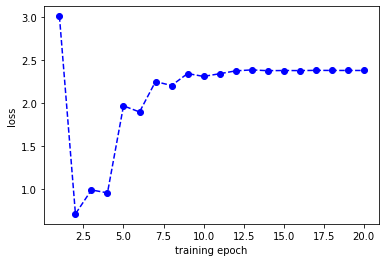

In [ ]:
best_val_loss = float('inf')
epoch_losses = []
for epoch in range(n_epochs):
    train_loss = train(model,train_loader)
    val_acc, val_loss = evaluate(model, valid_loader)
    print("epoch: %s, train_loss: %s, val_loss: %s, val_acc: %s\n" %(epoch, train_loss, val_loss, val_acc))
              
    epoch_losses.append(val_loss)
    lr_scheduler.step(val_loss)
        
    if val_loss < best_val_loss:
       best_val_loss = val_loss
       torch.save(model.state_dict(), 'best.pt')

utils.plot(epoch_losses)

# Testing

In [ ]:
#test the best model
model.load_state_dict(torch.load("best.pt"))
model.eval()
test_acc, test_loss = evaluate(model,test_loader)
print('The test accuracy is %s and test loss is %s' %(test_acc, test_loss))

'''
actuals, predictions = evaluate(model, test_iterator)
print('Confusion matrix:')
print(confusion_matrix(actuals, predictions))
print('F1 score: %f' % f1_score(actuals, predictions, average='micro'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))
'''

The test accuracy is 0.7546 and test loss is 0.6989458008324898


"\nactuals, predictions = evaluate(model, test_iterator)\nprint('Confusion matrix:')\nprint(confusion_matrix(actuals, predictions))\nprint('F1 score: %f' % f1_score(actuals, predictions, average='micro'))\nprint('Accuracy score: %f' % accuracy_score(actuals, predictions))\n"